/var/tmp/lazin1/ipykernel_1995053/482920385.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr",11) # define the colormap


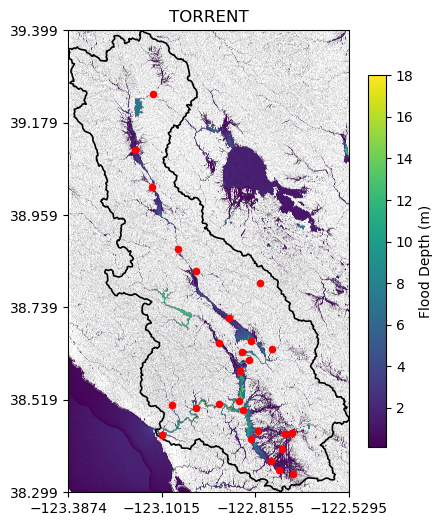

In [7]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
# import contextily as ctx
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
# import geopandas as gpd
# import pandas as pd

# Open the raster datasets
TORRENT = f"/p/lustre1/lazin1/flood/Sonoma/RussianRiver_2019-02-25_2019-03-04/peak-depth-1.tif"
TRITON = f"/p/vast1/lazin1/triton/output_corrected_event2/asc/MH_528_00_WGS84.tif"



points_file = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/Sonoma_gauge_height.csv"  # Text file containing X, Y coordinates
points_df = gpd.read_file(points_file) if points_file.endswith(".shp") else pd.read_csv(points_file)

# Keep only relevant columns
points_df = points_df[["STAID", "Lat", "Long"]].copy()

# Rename columns
points_df.rename(columns={"Lat": "Y", "Long": "X"}, inplace=True)

# Check if the file contains headers; if not, assume X, Y structure
if "X" not in points_df.columns or "Y" not in points_df.columns:
    points_df.columns = ["X", "Y"]

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(points_df["X"], points_df["Y"])]

with rasterio.open(TORRENT) as dataset1, rasterio.open(TRITON) as dataset2:
    # Read data
    data1 = dataset1.read(1)  # Read first band
    data2 = dataset2.read(1)
    
    
    data1[data1==0]=np.nan

    
    data2[data2==0]=np.nan

    
    data1 = np.ma.masked_equal(data1, dataset1.nodata)
    data2 = np.ma.masked_equal(data2, dataset2.nodata)
    
    transform1 = dataset1.transform  # Get the transform for projection
    transform2 = dataset2.transform  # Get the transform for projection
    
    crs1 = dataset1.crs  # Get the coordinate system
    crs2 = dataset2.crs  # Get the coordinate system
    
    
    # Calculate extent for correct georeferencing
    extent1 = [transform1.c, transform1.c + dataset1.width * transform1.a,
               transform1.f + dataset1.height * transform1.e, transform1.f]
    
    extent2 = [transform2.c, transform2.c + dataset2.width * transform2.a,
               transform2.f + dataset2.height * transform2.e, transform2.f]

    # Find global min/max for consistent color scale
    vmin = 0.1 #min(np.nanmin(data1), np.nanmin(data2))
    vmax = 18 #max(np.nanmax(data1), np.nanmax(data1))#18 #max(np.nanmax(data1), np.nanmax(data1))

    # Create figure
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))

    # Plot first raster
    img1 = axes.imshow(data1,extent=extent1,  cmap="viridis", vmin=vmin, vmax=vmax)
    # img1 = axes.imshow(data1,  cmap="viridis", vmin=vmin, vmax=vmax)
    axes.set_title("TORRENT")
    axes.set_aspect("equal")  # Ensure same aspect ratio


    

    points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs=crs2)
    
    SONOMA_SHP = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/11467270.shp"  # Update with the actual path to the shapefile


    # Read the shapefile
    sonoma_gdf = gpd.read_file(SONOMA_SHP)
    if sonoma_gdf.crs != crs1:
        sonoma_gdf = sonoma_gdf.to_crs(crs1)
        
    # Plot shapefile on both maps
    sonoma_gdf.plot(ax=axes, edgecolor="black", facecolor="none", linewidth=1.2, label="Sonoma Shapefile")
    # sonoma_gdf.plot(ax=axes[1], edgecolor="black", facecolor="none", linewidth=1.2)


    # Plot points on top
    # points_gdf.plot(ax=axes[1], color="red", marker="o", markersize=20, label="Points")
    
    # Set same x and y ticks for both plots
    axes.set_xticks(np.linspace(*axes.get_xlim(), num=4))
    axes.set_yticks(np.linspace(*axes.get_ylim(), num=6))
    # axes[1].set_xticks(axes[0].get_xticks())
    # axes[1].set_yticks(axes[0].get_yticks())
    
    # Ensure same x/y limits for both subplots
    # axes[1].set_xlim(axes[0].get_xlim())
    # axes[1].set_ylim(axes[0].get_ylim())
    
    # points_gdf.plot(ax=axes[1], color="red", marker="o", markersize=20, label="Points")
    # axes[1].scatter(points_gdf["X"].values, points_gdf["Y"].values, color="red", marker="o", s=20)
    axes.scatter(points_gdf["X"].values, points_gdf["Y"].values, color="red", marker="o", s=20)

    # Add a common colorbar
    cbar = fig.colorbar(img1, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Flood Depth (m)")
    plt.savefig("/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/TORRENT_max_depth.png")
    plt.show()


In [2]:
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def convert_raster_to_png(tif_path, png_path):
    with rasterio.open(tif_path) as src:
        array = src.read(1)
        array = np.where(array == src.nodata, np.nan, array)

        # Normalize for better display
        vmin = np.nanpercentile(array, 2)
        vmax = np.nanpercentile(array, 98)
        norm_array = (array - vmin) / (vmax - vmin)
        norm_array = np.clip(norm_array, 0, 1)

        # Convert to RGB using colormap
        cmap = plt.get_cmap('viridis')
        rgba_img = cmap(norm_array)  # shape: (H, W, 4)
        rgb_img = (rgba_img[:, :, :3] * 255).astype(np.uint8)
        im = Image.fromarray(rgb_img)
        im.save(png_path)

        # Get bounding box (in lat/lon)
        bounds = src.bounds
        return [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]


In [3]:
import folium.plugins
import branca
from branca.element import Template, MacroElement
import branca.colormap as bcmap
import numpy as np
import pandas as pd
fname= "index.html"
html_list=[] #Create an empty list to which we will append all the exported html files


# Convert and get bounds
tif_file = f"/p/lustre1/lazin1/flood/Sonoma/RussianRiver_2019-02-25_2019-03-04/peak-depth-1.tif"
png_test_file = f"/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/converted_geotiff.png"
png_file = f"/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/TORRENT_max_depth.png"
bounds = convert_raster_to_png(tif_file, png_test_file)

# Create folium map
m = folium.Map(location=[(bounds[0][0] + bounds[1][0]) / 2,
                         (bounds[0][1] + bounds[1][1]) / 2],
               zoom_start=10)

# Add raster overlay
img_overlay = folium.raster_layers.ImageOverlay(
    name="Flood Raster",
    image=png_file,
    bounds=bounds,
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)
img_overlay.add_to(m)

# Optional: Add layer control
folium.LayerControl().add_to(m)


df = pd.read_csv("/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/Sonoma_gauge_height.csv")

IDs = df['STAID'].unique() # Get the list of city names
for i, ID in enumerate(IDs, start = 0):
    html_list.append('fig'+str(ID).zfill(8)+'.html')
df["html_file"] = html_list
df.reset_index(drop=True,inplace=True)
df
# df3["V"] = pd.DataFrame([ x.split(',')[0] for x in cities])
# df3["city"]= df3["V"]
# df_lat_lon= pd.read_csv(r"/home/lazin1/ISIMIP_WaterGap/uscities.csv")
# df_lat_lon = df_lat_lon[df_lat_lon['city'].isin(df3["V"].values.tolist())]
# required_cols = [ "ID", "Lat", "Long", "100_change", "html_file"]
# df_final = df_final[required_cols]
# df_final = df_final.drop_duplicates(subset=['ID'])
# df_lat_lon["lat"]=df_lat_lon["lat"].astype('str')
# df_lat_lon["lng"]=df_lat_lon["lng"].astype('str')
# # lat_lon=pd.read_csv(r'cities_lat_lon.csv') #Add the latitude and longitude for each city so that we can later on add them to markers
# # df_final=df3.merge(lat_lon, on='city', how='left')
# # df_final= pd.merge(df3, df_lat_lon, how="inner")#on=idxs)
# # df_lat_lon = df_lat_lon.drop_duplicates(keep='first')
# df_final=df3.merge(df_lat_lon, on='city', how='left')
# df_final #Create a final dataframe that has city names, html file names,  latitude and longitude.
location = df['Lat'].mean(), df['Long'].mean()
# m = folium.Map(location=location,zoom_start=4)


# for i in range(0,len(df_final)):
#     html="""
#     <iframe src=\"""" + df_final['html_file'][i] + """\" width="850" height="400"  frameborder="0">    
#     """
    
#     popup = folium.Popup(folium.Html(html, script=True))
#     folium.Marker([df_final['Lat'].iloc[i],df_final['Long'].iloc[i]],
#                   popup=popup,icon=folium.Icon( icon='circle', prefix='fa')).add_to(m)
    

# f_map = folium.Map(location=[base_lat,base_lon], tiles="OpenStreetMap", zoom_start=17)
lat_ = [50.6823, 50.6822, 50.6821, 50.6820, 50.6819]
lon_ = [10.9396291, 10.9396279, 10.9396269, 10.9396265, 10.9396261]
acc_ = [11.0,44.5,149.9,319.1,540.0,752.6]
import matplotlib.cm as cm
import matplotlib
# cmap = cm.get_cmap("Reds",5)


from matplotlib import colors




cmap = cm.get_cmap("bwr",11) # define the colormap

color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

colormap = bcmap.LinearColormap(colors=color_list,index=[i for i in range(-50,60,10)],
                             vmin=-50, vmax=50,
                             caption='% Relative Change of Future 100-year flood (Late Century: 2050-2098)')

fg = folium.FeatureGroup(name=fname.split('.')[0])       

for pt in range(len(df)):
    html="""
    <iframe src=\"""" + df['html_file'][pt] + """\" width="1050" height="600"  frameborder="0">    
    """
    
    popup = folium.Popup(folium.Html(html, script=True))

    color = 'k'#colormap(df_final['100_change'].iloc[pt])
    fg.add_child(folium.CircleMarker(location=[df['Lat'].iloc[pt],df['Long'].iloc[pt]],
                                     radius=6,
                                     fill=True,
                                     color=color,
                                     fill_color=color,
                                     popup=popup))
    
textbox_css = """
{% macro html(this, kwargs) %}
<!doctype html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <title>Changes in Future Floods Across CONUS</title>
    <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.2.1/css/all.min.css" integrity="sha512-MV7K8+y+gLIBoVD59lQIYicR65iaqukzvf/nwasF0nqhPay5w/9lJmVM2hMDcnK1OnMGCdVK+iQrJ7lzPJQd1w==" crossorigin="anonymous" referrerpolicy="no-referrer"/>
    <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
    <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

    <script>
      $( function() {
        $( "#textbox" ).draggable({
          start: function (event, ui) {
            $(this).css({
              right: "auto",
              top: "auto",
              bottom: "auto"
            });
          }
        });
      });
    </script>
  </head>

  <body>
    <div id="textbox" class="textbox">
      <div class="textbox-title">Changes in Future Floods Across CONUS</div>
      <div class="textbox-content">
        <p>
        <b>Details:</b><br>
        <span style="display: inline-block; padding-left: 20px;">
            Lazin, Rehenuma, Giuliana Pallotta, and Celine Bonfils."Basin-Informed Flood Frequency Analysis Using Deep Learning<br> 
            Exhibits Consistent Projected Regional Patterns Over CONUS." <i>Scientific Reports</i> (2025)<br>
            <a href="https://doi.org/10.1038/s41598-025-97610-2" target="_blank">DOI : 10.1038/s41598-025-97610-2</a>.
        </span>
        </p>        
        <p>
        <b>Contact:</b><br>
        <span style="display: inline-block; padding-left: 20px;">
        Rehenuma Lazin (lazin1@llnl.gov).<br>
        </span>
        </p>
       </div>
    </div>
 
</body>
</html>

<style type='text/css'>
  .textbox {
    position: absolute;
    z-index:9999;
    border-radius:4px;
    background: rgba( 28, 25, 56, 0.25 );
    box-shadow: 0 8px 32px 0 rgba( 31, 38, 135, 0.37 );
    backdrop-filter: blur( 4px );
    -webkit-backdrop-filter: blur( 4px );
    border: 4px solid rgba( 215, 164, 93, 0.2 );
    padding: 10px;
    font-size:14px;
    right: 20px;
    bottom: 20px;
    color: black;
  }
  .textbox .textbox-title {
    color: black;
    text-align: center;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 22px;
    }
</style>
{% endmacro %}
"""
# configuring the custom style (you can call it whatever you want)
my_custom_style = MacroElement()
my_custom_style._template = Template(textbox_css)

# Adding my_custom_style to the map
m.get_root().add_child(my_custom_style)

m.add_child(fg)
m.add_child(colormap)
# title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format("Interactive Flood Maps")
# m.get_root().html.add_child(folium.Element(title))
m.save("index.html")

/var/tmp/lazin1/ipykernel_4182561/1226959145.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr",11) # define the colormap


In [11]:
import folium.plugins
import branca
from branca.element import Template, MacroElement
import branca.colormap as bcmap
import numpy as np
import pandas as pd
fname= "index.html"
html_list=[] #Create an empty list to which we will append all the exported html files


df = pd.read_csv("/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/Sonoma_gauge_height.csv")

IDs = df['STAID'].unique() # Get the list of city names
for i, ID in enumerate(IDs, start = 0):
    html_list.append(str(ID).zfill(8)+'.html')
df["html_file"] = html_list
df.reset_index(drop=True,inplace=True)
df

location = df['Lat'].mean(), df['Long'].mean()
m = folium.Map(location=location,zoom_start=4)



lat_ = [50.6823, 50.6822, 50.6821, 50.6820, 50.6819]
lon_ = [10.9396291, 10.9396279, 10.9396269, 10.9396265, 10.9396261]
acc_ = [11.0,44.5,149.9,319.1,540.0,752.6]
import matplotlib.cm as cm
import matplotlib
# cmap = cm.get_cmap("Reds",5)


from matplotlib import colors




cmap = cm.get_cmap("bwr",11) # define the colormap

color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

colormap = bcmap.LinearColormap(colors=color_list,index=[i for i in range(-50,60,10)],
                             vmin=-50, vmax=50,
                             caption='% Relative Change of Future 100-year flood (Late Century: 2050-2098)')

fg = folium.FeatureGroup(name=fname.split('.')[0])       

for pt in range(len(df)):
    html="""
    <iframe src=\"""" + df['html_file'][pt] + """\" width="1050" height="600"  frameborder="0">    
    """
    
    popup = folium.Popup(folium.Html(html, script=True))

    color = 'k'#colormap(df_final['100_change'].iloc[pt])
    fg.add_child(folium.CircleMarker(location=[df['Lat'].iloc[pt],df['Long'].iloc[pt]],
                                     radius=6,
                                     fill=True,
                                     color=color,
                                     fill_color=color,
                                     popup=popup))
    

# configuring the custom style (you can call it whatever you want)
my_custom_style = MacroElement()
my_custom_style._template = Template(textbox_css)

# Adding my_custom_style to the map
# m.get_root().add_child(my_custom_style)

m.add_child(fg)
# m.add_child(colormap)
# title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format("Interactive Flood Maps")
# m.get_root().html.add_child(folium.Element(title))
m.save("index.html")

/var/tmp/lazin1/ipykernel_4182561/1570836032.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr",11) # define the colormap


In [14]:
import folium.plugins
import branca
from branca.element import Template, MacroElement
import branca.colormap as bcmap
import numpy as np
import pandas as pd
fname= "index.html"
html_list=[] #Create an empty list to which we will append all the exported html files
import geopandas as gpd


df = pd.read_csv("/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/Sonoma_gauge_height.csv")

IDs = df['STAID'].unique() # Get the list of city names
for i, ID in enumerate(IDs, start = 0):
    html_list.append(str(ID).zfill(8)+'.html')
df["html_file"] = html_list
df.reset_index(drop=True,inplace=True)
df

location = df['Lat'].mean(), df['Long'].mean()
# m = folium.Map(location=location,zoom_start=4)
# Create folium map

# Load shapefile
gdf = gpd.read_file("/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/11467270.shp")  # Ensure test.shp and related files (.dbf, .shx, etc.) are in the same folder

# Convert to GeoJSON format (in memory)
geojson_data = gdf.to_json()

bounds = gdf.total_bounds
# m = folium.Map(location=[(bounds[0][0] + bounds[1][0]) / 2,
#                          (bounds[0][1] + bounds[1][1]) / 2],
#                zoom_start=10)



# Get bounds
minx, miny, maxx, maxy = gdf.total_bounds

# Compute center point of the bounds
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2

# Create folium map centered on shapefile bounds
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)


lat_ = [50.6823, 50.6822, 50.6821, 50.6820, 50.6819]
lon_ = [10.9396291, 10.9396279, 10.9396269, 10.9396265, 10.9396261]
acc_ = [11.0,44.5,149.9,319.1,540.0,752.6]
import matplotlib.cm as cm
import matplotlib
# cmap = cm.get_cmap("Reds",5)


from matplotlib import colors




cmap = cm.get_cmap("bwr",11) # define the colormap

color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

colormap = bcmap.LinearColormap(colors=color_list,index=[i for i in range(-50,60,10)],
                             vmin=-50, vmax=50,
                             caption='% Relative Change of Future 100-year flood (Late Century: 2050-2098)')

fg = folium.FeatureGroup(name=fname.split('.')[0])       

for pt in range(len(df)):
    html="""
    <iframe src=\"""" + df['html_file'][pt] + """\" width="1050" height="600"  frameborder="0">    
    """
    
    popup = folium.Popup(folium.Html(html, script=True))

    color = 'k'#colormap(df_final['100_change'].iloc[pt])
    fg.add_child(folium.CircleMarker(location=[df['Lat'].iloc[pt],df['Long'].iloc[pt]],
                                     radius=6,
                                     fill=True,
                                     color=color,
                                     fill_color=color,
                                     popup=popup))
    

# configuring the custom style (you can call it whatever you want)
# my_custom_style = MacroElement()
# my_custom_style._template = Template(textbox_css)

# Adding my_custom_style to the map
# m.get_root().add_child(my_custom_style)




# # Create a base map centered on the shapefile
# map_center = [gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()]
# m = folium.Map(location=map_center, zoom_start=10)

# Add GeoJSON overlay
folium.GeoJson(geojson_data, name="Shapefile Layer").add_to(m)

m.add_child(fg)




# m.add_child(colormap)
# title = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format("Interactive Flood Maps")
# m.get_root().html.add_child(folium.Element(title))
m.save("index.html")

/var/tmp/lazin1/ipykernel_4182561/3081727033.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr",11) # define the colormap


In [ ]:
import folium

# Convert and get bounds
tif_file = "/path/to/your/raster.tif"
png_file = "converted_raster.png"
bounds = convert_raster_to_png(tif_file, png_file)

# Create folium map
m = folium.Map(location=[(bounds[0][0] + bounds[1][0]) / 2,
                         (bounds[0][1] + bounds[1][1]) / 2],
               zoom_start=10)

# Add raster overlay
img_overlay = folium.raster_layers.ImageOverlay(
    name="Flood Raster",
    image=png_file,
    bounds=bounds,
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)
img_overlay.add_to(m)

# Optional: Add layer control
folium.LayerControl().add_to(m)

# Save
m.save("folium_map_with_raster.html")


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

def convert_raster_to_png(tif_path, png_path, shapefile=None, points_csv=None, title="Flood Depth Map", cmap_name="viridis"):
    with rasterio.open(tif_path) as src:
        array = src.read(1)
        array = np.where(array == src.nodata, np.nan, array)
        transform = src.transform
        crs = src.crs

        # Normalize for display
        vmin = np.nanpercentile(array, 2)
        vmax = np.nanpercentile(array, 98)
        norm_array = (array - vmin) / (vmax - vmin)
        norm_array = np.clip(norm_array, 0, 1)

        # Get extent for georeferencing
        extent = [transform.c, transform.c + src.width * transform.a,
                  transform.f + src.height * transform.e, transform.f]

        # Plot
        fig, ax = plt.subplots()
        img = ax.imshow(array, extent=extent, cmap=cmap_name, vmin=0.1, vmax=vmax)
        ax.set_title(title)
        ax.set_aspect("equal")

        # Optional: Overlay shapefile
        if shapefile:
            gdf = gpd.read_file(shapefile)
            if gdf.crs != crs:
                gdf = gdf.to_crs(crs)
            gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.2)

        # Optional: Overlay gauge points
        if points_csv:
            df = pd.read_csv(points_csv)
            df = df.rename(columns={"Lat": "Y", "Long": "X"})
            geometry = [Point(xy) for xy in zip(df["X"], df["Y"])]
            points_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
            if points_gdf.crs != crs:
                points_gdf = points_gdf.to_crs(crs)
            ax.scatter(points_gdf.geometry.x, points_gdf.geometry.y, color="red", marker="o", s=20, label="Gauge Stations")

        # Add colorbar
        cbar = fig.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
        cbar.set_label("Flood Depth (m)")

        plt.grid(True)
        plt.tight_layout()
        plt.savefig(png_path)
        plt.close()

# Example usage:
convert_raster_to_png(
    tif_path="/p/lustre1/lazin1/flood/Sonoma/RussianRiver_2019-02-25_2019-03-04/peak-depth-1.tif",
    png_path="/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/TORRENT_max_depth.png",
    shapefile="/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/11467270.shp",
    points_csv="/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/Sonoma_gauge_height.csv",
    title="TORRENT Flood Depth Map"
)


In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

def convert_raster_to_png(tif_path, png_path, shapefile=None, points_csv=None, title="Flood Depth Map", cmap_name="viridis"):
    with rasterio.open(tif_path) as src:
        array = src.read(1)
        array = np.where(array == src.nodata, np.nan, array)
        array[array==0]=np.nan
        transform = src.transform
        crs = src.crs

        # Normalize for display
        vmin = np.nanpercentile(array, 2)
        vmax = np.nanpercentile(array, 98)
        norm_array = (array - vmin) / (vmax - vmin)
        norm_array = np.clip(norm_array, 0, 1)

        # Get extent for georeferencing
        extent = [transform.c, transform.c + src.width * transform.a,
                  transform.f + src.height * transform.e, transform.f]

        # Plot
        fig, ax = plt.subplots()
        img = ax.imshow(array, extent=extent, cmap=cmap_name, vmin=0.1, vmax=18)
        ax.set_title(title)
        ax.set_aspect("equal")

        # Optional: Overlay shapefile
        if shapefile:
            gdf = gpd.read_file(shapefile)
            if gdf.crs != crs:
                gdf = gdf.to_crs(crs)
            gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.2)

        # Optional: Overlay gauge points
        if points_csv:
            df = pd.read_csv(points_csv)
            df = df.rename(columns={"Lat": "Y", "Long": "X"})
            geometry = [Point(xy) for xy in zip(df["X"], df["Y"])]
            points_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
            if points_gdf.crs != crs:
                points_gdf = points_gdf.to_crs(crs)
            ax.scatter(points_gdf.geometry.x, points_gdf.geometry.y, color="red", marker="o", s=20, label="Gauge Stations")

        # Add colorbar
        # cbar = fig.colorbar(img, ax=ax, orientation="vertical", fraction=0.02, pad=0.02)
        # cbar.set_label("Flood Depth (m)")
        
        # Remove ticks, labels, and title
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        ax.axis('off')

        # plt.grid(True)
        # plt.tight_layout()
        plt.savefig(png_path,bbox_inches='tight', pad_inches=0)
        plt.close()

        # Return bounds in [[south, west], [north, east]] format
        bounds = src.bounds
        return [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]
    
# Example usage:
convert_raster_to_png(
    tif_path="/p/lustre1/lazin1/flood/Sonoma/RussianRiver_2019-02-25_2019-03-04/peak-depth-1.tif",
    png_path="/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/TORRENT_max_depth.png",
    shapefile="/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/11467270.shp",
    points_csv="/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Sonoma_shapefile/Sonoma_gauge_height.csv",
    title="TORRENT Flood Depth Map"
)


[[38.298644454, -123.387438304], [39.39918691, -122.5294855530917]]